In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cebra import CEBRA
import pickle 
import cebra
np.random.seed(1)
import torch
from beh_data_analysis import run
import itertools
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

import cebra_datahelpers
import copy
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D


# Instructions to run this file 

This file runs cebra on the EPM data. The pre-trained model is provided to replicate the results of the paper. 
You can analyse the embeddings, barycenter distances, and the shannon entropy. 


In [ ]:
#import dataset
%matplotlib inline
partname = "snout"
l_mouse_name = ["M2498","M2502"]
l_date =["20230414","20230414"]
l_rotation = [0,1]
l_data,l_data_25, l_data_shuffled, l_data_shuffled_25, l_beh_lowdim, l_beh_shuffled, l_beh,l_beh_lowdim_cont,l_beh_shuffled_cont = cebra_datahelpers.load_datavariables(l_mouse_name, l_date, datatype=0, sorter="kilo")

[]
[]


In [ ]:
def binshuffle_15min(l_data, binwidth=0.05):
    np.random.seed(42)
    l_data_sh = []
    for i in range(len(l_data)):
        neural = np.array(l_data[i])
        summ = np.sum(neural)
        timep = l_data[i].shape[0]
        freq = 30000
        #t_ignore = int(30*0.05*30000)
        timeb_total = int(timep*freq*binwidth)# - t_ignore
        y = np.zeros((timeb_total, neural.shape[-1])).astype(int)
        for i in range(neural.shape[-1]):
            summ = np.sum(neural[:,i])
            t = (timeb_total*1)
            y[:,i] = np.random.binomial(n=1, p=summ/t, size=(timeb_total)).astype(int)
        new= np.zeros((neural.shape[0], neural.shape[-1]))
        c=int(30000*binwidth)
        for i in range(new.shape[0]):
            new[i,:] =np.sum(y[i*c:(i+1)*c,:], axis=0)
        
        l_data_sh.append(new)
        del new
    return l_data_sh

In [4]:
l_data_shuffled = binshuffle_15min(l_data.copy())

In [5]:
# Params
iter = 40000
def init_model_time(model_arch,max_iterations=40000, temp=1):
    return cebra.CEBRA(model_architecture=model_arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=temp,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        num_hidden_units=20,
                        verbose=True,
                        time_offsets=10)

In [ ]:
# # This block of code is run only once to define and train models 
# # to trian the model, uncomment and run this code
#If required, you can train the model on the provided dataset as well 

# iter = 40000
# model_pos_testtrain = init_model_time('offset5-model', max_iterations=iter)
# model_pos_testtrain.fit(l_data, l_beh_lowdim_cont)
# model_pos_testtrain.save("Results/Not-injected/cebra/model_time_3dim_20units_offset5_iter"+str(iter)+"_lr_3eminus4_offset10_kilo")

# embedding_pos_whole = [None]*len(l_mouse_name)

# for i in range(len(l_mouse_name)):
#     embedding_pos_whole[i] = model_pos_testtrain.transform(l_data[i],i)


# model_pos_testtrain_sh = init_model_time('offset5-model', max_iterations=iter)
# model_pos_testtrain_sh.fit(l_data_shuffled, l_beh_lowdim_cont)
# model_pos_testtrain_sh.save("Results/Not-injected/cebra/model_time_3dim_20units_offset5_iter"+str(iter)+"_lr_3eminus4_offset10_sh_kilo")

# embedding_pos_whole_sh = [None]*len(l_mouse_name)

# for i in range(len(l_mouse_name)):
#     embedding_pos_whole_sh[i] = model_pos_testtrain_sh.transform(l_data_shuffled[i],i)



pos: -0.7266 neg:  7.6054 total:  6.8788 temperature:  1.0000: 100%|██████████| 4000/4000 [00:37<00:00, 106.54it/s]
pos: -0.8456 neg:  7.7523 total:  6.9067 temperature:  1.0000: 100%|██████████| 4000/4000 [00:37<00:00, 105.41it/s]


# Visualisations

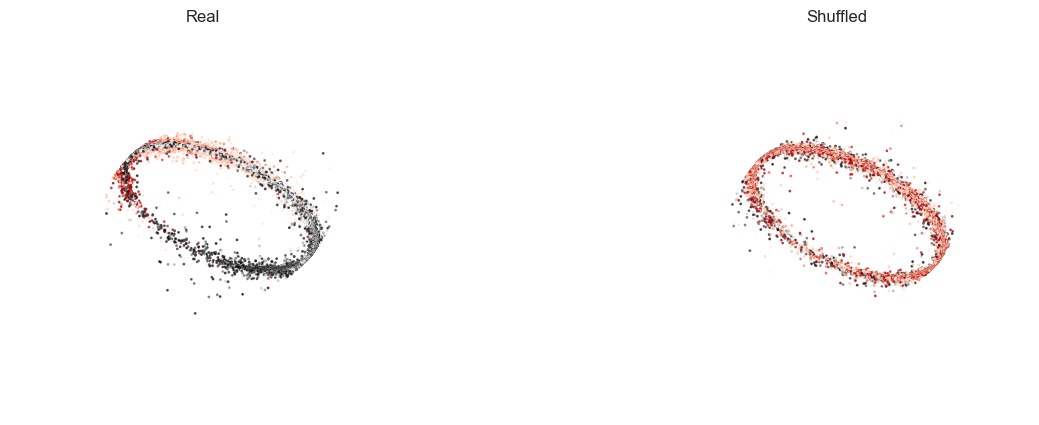

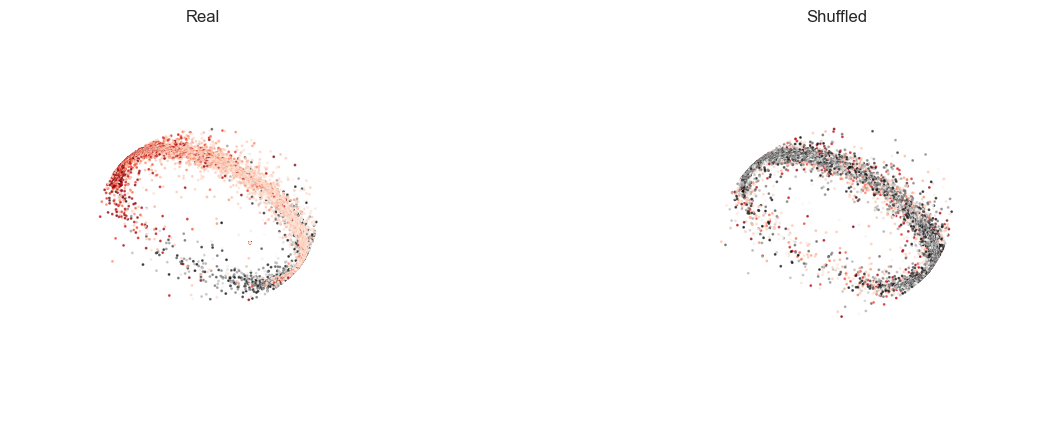

In [6]:
def plot_sh_real(emb_real , emb_sh, lbeh,lbeh_sh, c):
    
    idx_pos = lbeh[:,1]>=0
    idx_neg = lbeh[:,1]<0
    fig = plt.figure(figsize=(15,5))
    ax = [None]*2
    ax[0] = plt.subplot(121, projection='3d')
    ax[1] = plt.subplot(122, projection='3d')
    x=ax[0].scatter(emb_real[idx_pos,1],emb_real[idx_pos,2],emb_real[idx_pos,0], cmap="Reds", c=np.abs(lbeh[idx_pos,1]), s=1, alpha= 0.7)#, vmin=minv_pf,vmax=maxv_pf)cmap="Reds", c=np.abs(lbeh[idx_pos,1]
    y = ax[0].scatter(emb_real[idx_neg,1],emb_real[idx_neg,2],emb_real[idx_neg,0], cmap="Greys", c=np.abs(lbeh[idx_neg,1]), s=1, alpha = 0.7)#, vmin=minv_nf,vmax=maxv_nf)cmap="Greys", c=np.abs(lbeh[idx_neg,1]
    ax[0].set_title("Real")

    x=ax[1].scatter(emb_sh[idx_pos,1],emb_sh[idx_pos,2],emb_sh[idx_pos,0],cmap="Reds", c=np.abs(lbeh[idx_pos,1]), s=1, alpha= 0.7)#, vmin=minv,vmax=maxv)
    y = ax[1].scatter(emb_sh[idx_neg,1],emb_sh[idx_neg,2],emb_sh[idx_neg,0], cmap="Greys", c=np.abs(lbeh[idx_neg,1]), s=1, alpha = 0.7)#, vmin=minv,vmax=maxv_nf)
    ax[1].set_title("Shuffled")

    ax[0].xaxis.pane.fill = False
    ax[0].yaxis.pane.fill = False
    ax[0].zaxis.pane.fill = False

    ax[0].xaxis.pane.set_edgecolor('w')
    ax[0].yaxis.pane.set_edgecolor('w')
    ax[0].zaxis.pane.set_edgecolor('w')
    ax[0].axis('off')
    ax[1].xaxis.pane.fill = False
    ax[1].yaxis.pane.fill = False
    ax[1].zaxis.pane.fill = False

    ax[1].xaxis.pane.set_edgecolor('w')
    ax[1].yaxis.pane.set_edgecolor('w')
    ax[1].zaxis.pane.set_edgecolor('w')
    ax[1].axis('off')
    plt.show()

%matplotlib inline
embedding_pos_whole = [None]*len(l_data) #12
embedding_pos_whole_sh = [None]*len(l_data) #12

mod = cebra.CEBRA.load("Results/Not-injected/cebra/all_mice_model_time_3dim_20units_offset5_iter40000_lr_3eminus4_offset10_kilo_11mice")
mod_sh =  cebra.CEBRA.load("Results/Not-injected/cebra/all_mice_model_time_3dim_20units_offset5_iter40000_lr_3eminus4_offset10_sh_kilo_11mice")

mouse_indices = [7,10] # the mouse idx in the trained model

for i in range(len(l_data)):

    idx = np.arange(0, l_beh_lowdim_cont[i].shape[0], 1)
    idx_test = np.arange(0, l_beh_lowdim_cont[i].shape[0],1)
    
    embedding_pos_whole[i] = mod.transform(l_data[i], mouse_indices[i])
    embedding_pos_whole_sh[i] = mod.transform(l_data_shuffled[i],mouse_indices[i])
    plot_sh_real(embedding_pos_whole[i][:], embedding_pos_whole_sh[i][:], np.array(l_beh_lowdim_cont[i][idx,:]),np.array(l_beh_lowdim_cont[i][idx_test,:]), c=i)

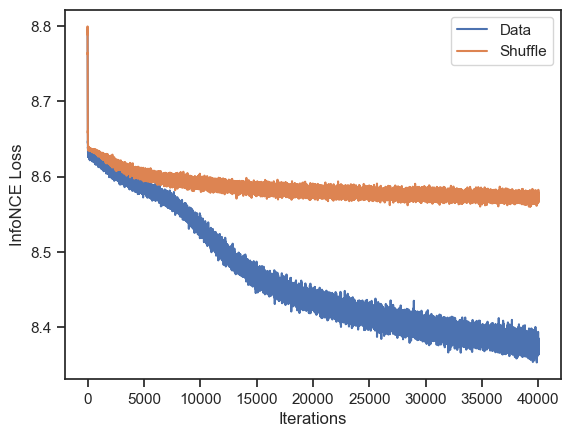

In [7]:
%matplotlib inline
iter = 40000
plt.plot(np.arange(0, iter),mod.solver_.history, label="Data")
plt.plot(np.arange(0, iter),mod_sh.solver_.history, label="Shuffle")
plt.ylabel('InfoNCE Loss')
plt.xlabel('Iterations')
plt.legend()
# plt.savefig('RESULTS/NOT-INJECTED/cebra/Plots//Multsess_Offset5_loss_kilo2.svg')
plt.show()


# DECODING

In [8]:
from cebra import KNNDecoder,L1LinearRegressor
from sklearn.model_selection import train_test_split

score_train_cont,score_whole_cont, score_cont = [None]*len(l_mouse_name), [None]*len(l_mouse_name),[None]*len(l_mouse_name)
score_train_cont_sh,score_whole_cont_sh, score_cont_sh = [None]*len(l_mouse_name), [None]*len(l_mouse_name),[None]*len(l_mouse_name)

for i in range(len(l_mouse_name)):
    
    emb_wh = embedding_pos_whole[i]
    emb_train, emb_test, l_beh_lowdim_train, l_beh_lowdim_test = train_test_split(emb_wh, (l_beh_lowdim_cont[i][:,0:2]))
    
    decoder = KNNDecoder(n_neighbors=100)
    decoder.fit(X=emb_train, y=l_beh_lowdim_train[:,1])

    score_train_cont[i] = decoder.score(X=emb_train, y=(l_beh_lowdim_train[:,1]))
    score_cont[i] = decoder.score(X=emb_test, y=(l_beh_lowdim_test[:,1]))

    score_whole_cont[i] = decoder.score(X=emb_wh, y=(l_beh_lowdim_cont[i][:,1]))


    emb_wh = embedding_pos_whole_sh[i]
    emb_train, emb_test, l_beh_lowdim_train, l_beh_lowdim_test = train_test_split(emb_wh, (l_beh_lowdim_cont[i][:,0:2]))
    
    decoder = KNNDecoder(n_neighbors=100)
    decoder.fit(X=emb_train, y=l_beh_lowdim_train[:,1])

    score_train_cont_sh[i] = decoder.score(X=emb_train, y=(l_beh_lowdim_train[:,1]))
    score_cont_sh[i] = decoder.score(X=emb_test, y=(l_beh_lowdim_test[:,1]))

    score_whole_cont_sh[i] = decoder.score(X=emb_wh, y=(l_beh_lowdim_cont[i][:,1]))
    

In [ ]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import svm

def add_class(beh):
    classvar = []#np.zeros(np.array(beh).shape[0])
    idx = []
    for i in range(beh.shape[0]):
        if beh[i,0] == 0 or beh[i,0] == 1 or beh[i,0] == -1:
            classvar.append(1)
            idx.append(i)
        elif beh[i,0]==2 or beh[i,0] == 3:
            classvar.append(0)
            idx.append(i)
        else:
            continue
    #beh = np.array(beh)
    #beh_new = np.vstack((beh.T, classvar)).T

    return np.array(classvar), idx



def classifier(emb_train, emb_test, beh_train, beh_test,n_neighbors=100):
    decoder = KNeighborsClassifier(n_neighbors=n_neighbors) #svm.SVC()
    decoder.fit(emb_train, beh_train)
    score_train = decoder.score(X=emb_train, y=beh_train)

    score = decoder.score(X=emb_test, y=beh_test)
    return score_train, score#, accuracy

score_train, score = [None]*len(l_mouse_name), [None]*len(l_mouse_name)
score_train_sh, score_sh = [None]*len(l_mouse_name), [None]*len(l_mouse_name)

time_OA = []
time_all = []
time_all_centre = []

for i in range(len(l_mouse_name)):
    beh, idx = add_class(l_beh_lowdim_cont[i][:,0:2])
    time_OA.append(np.sum(1*np.array(beh == 1)))
    time_all.append(len(beh))
    time_all_centre.append((l_beh_lowdim_cont[i][:,0].shape[0]))
    emb = embedding_pos_whole[i][idx, :]
    emb_train, emb_test, l_beh_lowdim_train, l_beh_lowdim_test = train_test_split(emb, beh)
    score_train[i], score[i]=classifier(emb_train, emb_test, l_beh_lowdim_train,l_beh_lowdim_test)

    emb = embedding_pos_whole_sh[i][idx, :]
    emb_train, emb_test, l_beh_lowdim_train, l_beh_lowdim_test = train_test_split(emb, beh)
    score_train_sh[i], score_sh[i]=classifier(emb_train, emb_test, l_beh_lowdim_train,l_beh_lowdim_test, n_neighbors=100)

closed_arm_frac = 1-np.array(time_OA)/np.array(time_all)

In [ ]:
score = np.array(score)
score_sh = np.array(score_sh)
closed_arm_frac = np.array(closed_arm_frac)
normalised_real_dec = score * 0.5/closed_arm_frac
normalised_sh_dec = score_sh * 0.5/closed_arm_frac

Text(0.5, 1.0, 'OA vs CA Decoding, normalised')

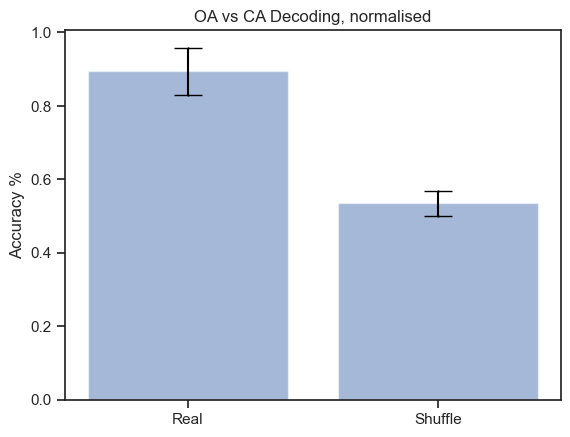

In [11]:
from scipy.stats import sem

mean_real = np.mean(normalised_real_dec)
mean_sh = np.mean(normalised_sh_dec)
sem_real = sem(normalised_real_dec)
sem_sh = sem(normalised_sh_dec)
plt.bar([0,1], [mean_real, mean_sh], yerr=[sem_real, sem_sh], alpha=0.5,align='center', ecolor='black', capsize=10,)
plt.scatter(np.zeros(len(l_mouse_name)), normalised_real_dec, c='k', s=0.5)
plt.scatter(np.ones(len(l_mouse_name)), normalised_sh_dec, c='k', s=0.5)
plt.ylabel('Accuracy %')
plt.xticks([0,1], ['Real', 'Shuffle'])
plt.title('OA vs CA Decoding, normalised')
# plt.savefig('RESULTS/NOT-INJECTED/cebra/Plots/OAvCAdecoder_kilo2.svg') 


# Barycentre Analysis

In [ ]:
dist =np.zeros(len(l_mouse_name))
dist_sh =np.zeros(len(l_mouse_name))
emb_pos, emb_neg = [None]*len(embedding_pos_whole), [None]*len(embedding_pos_whole)
emb_pos_sh, emb_neg_sh = [None]*len(embedding_pos_whole), [None]*len(embedding_pos_whole)
emb_positive, emb_negative = [None]*len(embedding_pos_whole), [None]*len(embedding_pos_whole)
emb_positive_sh, emb_negative_sh = [None]*len(embedding_pos_whole), [None]*len(embedding_pos_whole)


%matplotlib inline

def clusterAnalysis(emb, beh):
    # all behaviour beyond 100 pix and -100 pix
    dist = []
    idx_beh_pos = beh>=140
    idx_beh_neg = beh<=-140
    emb_pos = np.average(emb[idx_beh_pos, :], axis=0)
    emb_neg = np.average(emb[idx_beh_neg, :], axis=0)
    dist = np.linalg.norm(emb_pos-emb_neg)
    return dist, emb[idx_beh_pos, :],emb[idx_beh_neg, :], emb_pos, emb_neg

for i in range(len(l_mouse_name)):
    dist[i],emb_pos[i], emb_neg[i],emb_positive[i],emb_negative[i]  = clusterAnalysis(embedding_pos_whole[i], l_beh_lowdim_cont[i][:,1])
    dist_sh[i],emb_pos_sh[i], emb_neg_sh[i], emb_positive_sh[i],emb_negative_sh[i]  = clusterAnalysis(embedding_pos_whole_sh[i], l_beh_lowdim_cont[i][:,1])
dist = np.array(dist)
dist_sh = np.array(dist_sh)

In [ ]:
import statsmodels.api as sm
dist = np.array(dist)
dist_sh = np.array(dist_sh)
time_t =np.array(time_OA)/np.array(time_all_centre) 


In [ ]:
def shannon_entropy(embedding, l_beh):
    all_mouse_entropy_OA = []
    all_mouse_entropy_CA = []

    for i,(emb, lbeh) in enumerate(zip(embedding, l_beh)):
    
        idx_pos = lbeh[:, 1] >= 0
        idx_neg = lbeh[:, 1] < 0

        openarm_points = emb[idx_pos, :]
        closedarm_points = emb[idx_neg, :]
     
        x_edges = np.arange(-1, 1, 0.05)
        y_edges = np.arange(-1, 1, 0.05)
        z_edges= np.arange(-1, 1, 0.05)

        hist_OA, edges = np.histogramdd(openarm_points, bins=[x_edges, y_edges, z_edges])
        hist_OA = hist_OA.flatten()
      
        
        prob_OA = hist_OA / len(emb)
        prob_OA = prob_OA[prob_OA>0]

   
        entropy_OA = -np.sum(prob_OA * np.log2(prob_OA))
        all_mouse_entropy_OA.append(entropy_OA)


        hist_CA, edges = np.histogramdd(closedarm_points, bins = [x_edges, y_edges, z_edges])  
   
        hist_CA = hist_CA.flatten()


       
        #for equal points!     
        hist_CA = hist_CA[hist_CA>0]
        # print("points of the non zero CA",len(hist_CA))

        # print('percentage of points removed:', ((1-(len(prob_OA)/len(hist_CA)))*100))

        if len(prob_OA)>len(hist_CA):
            len_to_consider = len(hist_CA)
        else:
            len_to_consider = len(prob_OA)

        hist_CA = hist_CA[np.random.choice(hist_CA.shape[0], len_to_consider)]
        #end here 



        prob_CA = hist_CA / len(emb)

        prob_CA = prob_CA[prob_CA>0]
        # print('print the length of CA', len(prob_CA))
      
        
        entropy_CA = -np.sum(prob_CA * np.log2(prob_CA))
        all_mouse_entropy_CA.append(entropy_CA)


    return all_mouse_entropy_OA, all_mouse_entropy_CA

In [21]:
all_mouse_entropy_OA , all_mouse_entropy_CA  = shannon_entropy(embedding_pos_whole, l_beh_lowdim_cont)

In [22]:
all_mouse_entropy_OA_sh , all_mouse_entropy_CA_sh  = shannon_entropy(embedding_pos_whole_sh, l_beh_lowdim_cont)

In [ ]:
def plot_stat(openarm, closearm):
    openarm_mean_vehicle = np.mean(openarm)
    closedarm_mean_vehicle = np.mean(closearm)
    x_pos = [0, 1]
    colors = ['#B0B0B0', '#FF6F61']


    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x_pos, [closedarm_mean_vehicle, openarm_mean_vehicle], color=colors)


    scatter_colors = ['#000000', '#000000']

    ax.scatter(np.full(len(closearm), x_pos[0]), closearm, 
               color=scatter_colors[0], label='closearm', alpha=0.8)
    ax.scatter(np.full(len(openarm), x_pos[1]), openarm, 
               color=scatter_colors[1], label='openarm', alpha=0.8)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(['closearm', 'openarm'])
    ax.set_ylabel('Entropy', fontsize=14, fontweight='bold')
    ax.set_title('Shannon Entropy', fontsize=16)
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()


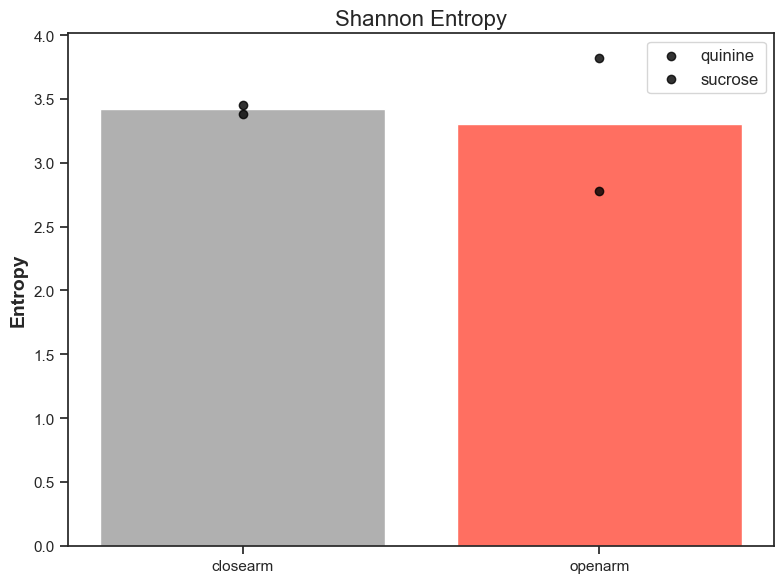

In [27]:
plot_stat(all_mouse_entropy_CA, all_mouse_entropy_OA )